In [137]:
%matplotlib inline

In [138]:
#parallel
from ipyparallel import Client
rc = Client(profile="default")
dview = rc[:] # use all engines
lv = rc.load_balanced_view()

In [201]:
%%px --local
import os,  ast
import numpy as np
import pandas as pd
import vcf, pyfasta
import matplotlib as mpl
from matplotlib import pyplot as plt

africa_pops3 = ["aet","cyn","pyn","pys","sab","tan"]
pops3 = ["aet","cyn","pyn","pys","sab",'sac','sar',"tan"]

chromosomes = ["CAE" + str(i) for i in range(1,30) + ["X"] + ['Y'] ]
eu = os.path.expanduser
jn = os.path.join
var_ana_dir = eu("~/vervet_project/analyses/20150504_163_UnifiedGenotyper/_data")
variant_impact_dir = eu("~/vervet_project/analyses/20160516_variant_impact/_data")
meta_dir = eu("~/vervet_project/metadata")



def str_to_dic(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        print s
        raise
        
mt = pd.read_csv(jn(meta_dir,"163_master_table.csv"),
                 index_col=0,
                 converters={"library":str_to_dic, "phenotypes":str_to_dic})


#gene_df_ensembl = pd.read_csv(jn(meta_dir,"annot_ensemble_1.1.77_genes.tsv"),sep="\t",index_col=[0,1])
#gene_df_ensembl_CDS = pd.read_csv(jn(meta_dir,"annot_ensemble_1.1.77_CDS.tsv"),sep="\t",index_col=[0,1])
mac_seq = pyfasta.Fasta(eu("~/vervet_project/data/other_species/Macaca_mulatta/CR_1.0_in_vervet_coord_ref3500.fa"))
#gene_df_r100 = pd.read_csv(jn(meta_dir,"annot_release100_genes.tsv"),sep="\t",index_col=[0,1])
#gene_df_r100_exons = pd.read_csv(jn(meta_dir,"annot_release100_exons.tsv"),sep="\t",index_col=[0,1])
#attention, upgrade to ensembl 1.1.78!!!
#gene_df_ensembl = pd.read_csv(jn(meta_dir,"annot_ensemble_1.1.77_genes.tsv"),sep="\t",index_col=[0,1])

In [150]:
%%px --local

import re
import subprocess, gzip

def add_info_line(info_dic, line):
    #split all commas except if in quotes
    r = re.compile('[^,]+".+"[^,]*'
                '|'
                '[^,]+')
    try:
        category, value = line.strip().split('=<')
    except ValueError:
        try: 
            info_dic["uncategorised"].update({line.strip().split('=')[0][2:]:line.strip().split('=')[1]})
        except KeyError:
            try:
                info_dic.update({"uncategorised":{line.strip().split('=')[0][2:]:line.strip().split('=')[1]}})
            except ValueError, e:
                print line.strip().split('=')
                raise e
        return
    category = category[2:]
    tags = r.findall(value[:-1])
    subdic = {k:v for k,v in [t.split('=',1) for t  in tags]}
    try:
        info_dic[category].update({subdic["ID"]:subdic})
    except KeyError:
        info_dic.update({category:{subdic["ID"]:subdic}})
        
def parse_vcf_header(fn):
    info_dic = {}
    fh = gzip.open(fn) if fn[-3:] == ".gz" else open(fn)
    for line in fh:
        if line[:6] == "#CHROM":
            header = line.strip().split('\t')
            header[0] = header[0][1:]
        else:
            add_info_line(info_dic, line)
        if line[0] != '#':
            break
    return header, info_dic

In [140]:
%%px --local
def get_vcf_df(fn, chrom, start, end, header=None, **kwa):
    if header is None:
        header, _ = parse_vcf_header(fn)
    tabix_stream = subprocess.Popen(['tabix',fn,"{}:{}-{}".format(chrom,start,end)], stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    vcf_df = pd.read_csv(tabix_stream.stdout, sep="\t", index_col=[0,1], header=False, names = header, **kwa)
    
    return vcf_df

## Get SNPeff annotations for peak regions, including filtered sites and including macacaque differences

In [141]:
peaks = [("CAE1",2467224),("CAE1",2757224),("CAE1",7005224),
         ("CAE2",50381341),("CAE4",5189544),("CAE5",13975063),
        ("CAE5",60269063),("CAE5",74650063), ("CAE6",3823905),
        ("CAE6",5564905),("CAE6",11705905),("CAE6",29586905),
        ("CAE8",117925766),("CAE10",104389305),
        ("CAE14",17153077),("CAE14",98746077),("CAE15",62257003),
        ("CAE16",1907271),("CAE16",6963271),("CAE16",7241271),("CAE16",57481271),
        ("CAE16",59802271),("CAE16",68026271),("CAE17",44458229),("CAE17",54486229),
        ("CAE18",62028538),("CAE20",18933658),("CAE20",106492658),("CAE20",111605658),
        ("CAE22",10431400),("CAE23",250753),("CAE23",42363534),("CAE24",3453536),
        ("CAE24",8944536),("CAE25",61650817),("CAE26",18910982),("CAE29",18370875),
        ("CAE29",21874875)]

In [142]:
%%px --local
def get_genotype_df(chrom, start,end):
    vcf_fn = jn(var_ana_dir,"163_UG_ref3500_all_sites_{}_filter_anc_mac_diff_ensembl_1.1.78.vcf.gz".format(chrom))


    header, info_dic = parse_vcf_header(vcf_fn)
    samples = header[9:]

    converters = {"INFO":get_info_dic}
    converters.update({n:get_genotype for n in samples})#{i:get_genotype for t in range(9,len(header))}

    vcf_df = get_vcf_df(vcf_fn, chrom, start, end, header=header, converters=converters)
    
    return vcf_df

In [143]:
%%px --local
def get_genotype(s):
    gt_str = s.split(':',1)[0]
    if gt_str[:3] in ["0/0","0|0"]:
        return 0
    elif gt_str[:3] in ["1/1","1|1"]:
        return 2
    elif gt_str[:3] in ["0/1","0|1","1|0"]:
        return 1
    else:
        return np.nan
    
def get_info_dic(s):
    info_tuples = [t.split('=') for t in s.split(';')]
    info_tuples = [t for t in info_tuples if len(t)==2]
    tags = [t for t in info_tuples if len(t)!=2]
#    try:
    d = {k:v for (k,v) in info_tuples}
    d.update({'_tags':tags})
#    except ValueError:
#        d = {}
#        logging.warning("Can not parse info column at {}:{}".format(line[0],line[1]))
    return d

def group_by_pop(col,poptype="pop3"):
    return mt.ix[col][poptype]

In [144]:
%%px --local
def try_dic(dic,key):
    try:
        return dic[key]
    except KeyError:
        return np.nan

def get_ith_annotation(el,i):
    try:
        return el.split(',')[i]
    except IndexError:
        return np.nan
def split_annotation(s):
    return pd.Series(s.split('|')[:4]+s.split('|')[-1:],index=['allele','effect','impact','gene_symbol','errors'])

In [146]:
%%px --local
def get_variant_annot_df(vcf_df, sample_ids=None):
    #remove non-seggregating
    
    if sample_ids is None:
        sample_ids = vcf_df.columns.values[7:]
    vcf_df = vcf_df[vcf_df['ALT'] != '.']

    subpop_af_df = vcf_df[sample_ids].groupby(group_by_pop,axis=1).apply(lambda df: df.mean(axis=1)/2.)
    annot_df = vcf_df[["REF","ALT","FILTER"]]
    annot_df.loc[:,'AA'] = vcf_df['INFO'].apply(lambda d:try_dic(d,"AA"))
    annot_df.loc[:,'AF'] = vcf_df[sample_ids].mean(axis=1)/2.

    annot_s = vcf_df['INFO'].apply(lambda d:try_dic(d,"ANN"))



    #annotation lowest level
    level0_df = annot_s.apply(lambda el:get_ith_annotation(el,0)).apply(split_annotation)
    level0_df = pd.concat([annot_df,level0_df,subpop_af_df],axis=1)
    level0_df.set_index("gene_symbol",append=True,inplace=True)
    tot_level_df = level0_df
    i =1
    for i in range(1,100):
        level_info = annot_s.apply(lambda el:get_ith_annotation(el,i)).dropna()   
        if not len(level_info):
            break
        level_df = level_info.apply(split_annotation)
        level_df = annot_df.ix[level_df.index].join(level_df,how='left').join(subpop_af_df, how='left')
        level_df.set_index("gene_symbol",append=True,inplace=True)
        tot_level_df = pd.concat([tot_level_df, level_df])
    return tot_level_df

In [145]:
%%px --local
def get_annot(chrom, pos, distance):
    start = pos-distance
    end = pos+distance
    try:
        vcf_df = get_genotype_df(chrom, start,end)
        annot_df = get_variant_annot_df(vcf_df)
    except Exception, e:
        return str(e)
    return annot_df

In [151]:
#look at peak regions
peak_map = lv.map_async(lambda p:get_annot(p[0],p[1],50000),peaks)

In [152]:
peak_map.wait(10)

In [149]:
peak_map.result[0]

"global name 'parse_vcf_header' is not defined"

In [353]:
[err for err in peak_map.result if type(err)==str]

['Too many columns specified: expected 172 and found -1']

In [355]:
annot_f = pd.concat([r for r in peak_map.result if type(r)!=str])

In [21]:
annot_f.shape

NameError: name 'annot_f' is not defined

In [361]:
annot_f[annot_f['impact']=='MODERATE'].xs('RANBP3',level=2)

REF ALT FILTER   AA        AF allele            effect  \
CHROM POS                                                              
CAE6  5576627   G   A   PASS  NaN  0.000000      A  missense_variant   
      5576646   C   T  ExCov  NaN  0.081250      T  missense_variant   
      5576672   G   A  ExCov  NaN  0.000000      A  missense_variant   
      5576717   G   A  ExCov  NaN  0.000000      A  missense_variant   
      5586838   A   G   PASS  NaN  0.015924      G  missense_variant   

                 impact errors       aet      cyn  pyn  pys  sab  sac  sar  \
CHROM POS                                                                    
CAE6  5576627  MODERATE         0.000000  0.00000    0    0    0    0    0   
      5576646  MODERATE         0.766667  0.09375    0    0    0    0    0   
      5576672  MODERATE         0.000000  0.00000    0    0    0    0    0   
      5576717  MODERATE         0.000000  0.00000    0    0    0    0    0   
      5586838  MODERATE         0.000000  0.15625    0    0    0    0    0   

               tan  
CHROM POS           
CAE6  5576627    0  
      5576646    0  
      5576672    0  
      5576717    0  
      5586838    0

In [362]:
annot_f[annot_f['impact']=='MODERATE'].xs('NFIX',level=2)

,,REF,ALT,FILTER,AA,AF,allele,effect,impact,errors,aet,cyn,pyn,pys,sab,sac,sar,tan
CHROM,POS,,,,,,,,,,,,,,,,,
CAE6,11707284,T,G,PASS,NaN,0,G,missense_variant,MODERATE,,0,0,0,0,0,0,0,0


In [ ]:
annot_f[annot_f['impact']=='MODERATE'].xs('NFIX',level=2)

In [309]:
define a metric for af differentiation....

REF   ALT                         FILTER AA        AF  \
CHROM POS                                                                 
CAE16 6955661       T     C                          ExCov  T  0.215190   
      6955663       G     A                 5bpIndel;ExCov  G  0.035948   
      6955667       T   TAG                 5bpIndel;ExCov  T  0.613924   
      6955676       G     C                          ExCov  C  0.000000   
      6955704       T     C                          ExCov  C  0.706250   
      6955828       C     G                       5bpIndel  G  0.000000   
      6955832       T   TCC                       5bpIndel  T  0.009375   
      6955865       C     T                           PASS  C  0.003106   
      6956049       T     C                          ExCov  C  0.000000   
      6956068       G     T                          ExCov  G  0.560127   
      6956089      AG     A  5bpIndel;ExCov;QualityByDepth  A  0.018868   
      6956108       C     T   ExCov;LowQual;QualityByDepth  C  0.016026   
      6956109       A     G   ExCov;LowQual;QualityByDepth  A  0.016129   
      6956128       A    AT  5bpIndel;ExCov;QualityByDepth  A  0.036184   
      6956129       T     G  5bpIndel;ExCov;QualityByDepth  T  0.019481   
      6956242       C    CG                 5bpIndel;ExCov  C  0.020000   
      6956243       C   A,G                 5bpIndel;ExCov  C  0.011719   
      6956294       G     A                          ExCov  G  0.006329   
      6956384       C     T                  ExCov;LowQual  C  0.003205   
      6956404       G     A                          ExCov  G  0.215686   
      6956431       G     C                          ExCov  G  0.013245   
      6956546       G     C                       5bpIndel  G  0.036424   
      6956548       G  GCTT                       5bpIndel  G  0.029801   
      6956569      CT     C                       5bpIndel  C  0.019481   
      6956573       C     G                       5bpIndel  C  0.417219   
      6956606       C     T                           PASS  C  0.019231   
      6956615       A     G                           PASS  G  0.593333   
      6956663       A     G                           PASS  A  0.024845   
      6956676       G     C                           PASS  C  0.000000   
      6956677       G     A                           PASS  A  0.000000   
...               ...   ...                            ... ..       ...   
      6958637       G     A                           PASS  A  0.000000   
      6958672       G     T               5bpIndel;LowQual  T  0.000000   
      6958672       G     T               5bpIndel;LowQual  T  0.000000   
      6958672       G     T               5bpIndel;LowQual  T  0.000000   
      6958672       G     T               5bpIndel;LowQual  T  0.000000   
      6958672       G    GC                       5bpIndel  T  0.006536   
      6958672       G    GC                       5bpIndel  T  0.006536   
      6958672       G    GC                       5bpIndel  T  0.006536   
      6958672       G    GC                       5bpIndel  T  0.006536   
      6958672       G     T               5bpIndel;LowQual  T  0.000000   
      6958672       G     T               5bpIndel;LowQual  T  0.000000   
      6958672       G     T               5bpIndel;LowQual  T  0.000000   
      6958672       G     T               5bpIndel;LowQual  T  0.000000   
      6958672       G    GC                       5bpIndel  T  0.006536   
      6958672       G    GC                       5bpIndel  T  0.006536   
      6958672       G    GC                       5bpIndel  T  0.006536   
      6958672       G    GC                       5bpIndel  T  0.006536   
      6958686  AACCCC     A                       5bpIndel  A  0.003226   
      6958703       C     T                           PASS  C  0.519481   
      6958758       C     T                           PASS  T  0.000000   
      6958770       C     T                

In [310]:
tot_level_df[tot_level_df["impact"]=='MODERATE'].xs("CD68",level=2)

REF ALT         FILTER AA        AF allele            effect  \
CHROM POS                                                                    
CAE16 6957216   G   A          ExCov  G  0.003205      A  missense_variant   
      6957221   G   A          ExCov  G  0.009615      A  missense_variant   
      6957354   G   A          ExCov  G  0.056962      A  missense_variant   
      6957485   A   G          ExCov  A  0.022727      G  missense_variant   
      6957509   G   A          ExCov  A  0.000000      A  missense_variant   
      6957557   A   G          ExCov  G  0.000000      G  missense_variant   
      6957623   C   T          ExCov  C  0.022876      T  missense_variant   
      6957677   A   G  ExCov;LowQual  G  0.000000      G  missense_variant   
      6957762   T   C          ExCov  T  0.097484      C  missense_variant   
      6957774   C   T          ExCov  T  0.000000      T  missense_variant   
      6957835   G   A  ExCov;LowQual  G  0.003185      A  missense_variant   
      6958256   T   C          ExCov  C  0.000000      C  missense_variant   
      6958279   G   C          ExCov  G  0.276730      C  missense_variant   

                 impact errors      aet       cyn  pyn       pys       sab  \
CHROM POS                                                                    
CAE16 6957216  MODERATE         0.03125  0.000000    0  0.000000  0.000000   
      6957221  MODERATE         0.00000  0.000000    0  0.030000  0.000000   
      6957354  MODERATE         0.56250  0.000000    0  0.000000  0.000000   
      6957485  MODERATE         0.21875  0.000000    0  0.000000  0.000000   
      6957509  MODERATE         0.00000  0.000000    0  0.000000  0.000000   
      6957557  MODERATE         0.00000  0.000000    0  0.000000  0.000000   
      6957623  MODERATE         0.00000  0.033333    0  0.058824  0.000000   
      6957677  MODERATE         0.00000  0.000000    0  0.000000  0.000000   
      6957762  MODERATE         0.00000  0.000000    0  0.303922  0.000000   
      6957774  MODERATE         0.00000  0.000000    0  0.000000  0.000000   
      6957835  MODERATE         0.00000  0.000000    0  0.000000  0.000000   
      6958256  MODERATE         0.00000  0.000000    0  0.000000  0.000000   
      6958279  MODERATE         0.00000  0.000000    0  0.000000  0.708333   

                    sac  sar       tan  
CHROM POS                               
CAE16 6957216  0.000000  0.0  0.000000  
      6957221  0.000000  0.0  0.000000  
      6957354  0.000000  0.0  0.000000  
      6957485  0.000000  0.0  0.000000  
      6957509  0.000000  0.0  0.000000  
      6957557  0.000000  0.0  0.000000  
      6957623  0.000000  0.0  0.000000  
      6957677  0.000000  0.0  0.000000  
      6957762  0.000000  0.0  0.000000  
      6957774  0.000000  0.0  0.000000  
      6957835  0.000000  0.0  0.045455  
      6958256  0.000000  0.0  0.000000  
      6958279  0.758065  0.7  0.000000

In [37]:
chrom = "CAE1"

In [38]:
variant = open(jn(var_ana_dir,"163_UG_ref3500_all_sites_{}_filter_anc_mac_diff_ensembl_1.1.78.vcf.gz".format(chrom)))

In [40]:
t = tabix.open(variant.name)

## For all genes: get for "pass" variants number of syn, nonsyn, high impact and allele frequencies in each category in all pops

In [118]:
%%px --local
from pypopgen.modules import vcfpandas

In [119]:
%%px --local
import gc
def get_annot_pass_all_genes(chrom):
    try:
        fn = jn(var_ana_dir,
                            "GATK_UG_163NonVRC_ref3500_{}_snp_pass"
                            "_beagle4_shapeit_notrb_ensembl_1.1.78.vcf.gz".format(chrom))

        header, _ = vcfpandas.parse_vcf_header(fn)
        samples = header[9:]


        converters = {"INFO":vcfpandas.get_info_dic}
        converters.update(vcfpandas.converters.genotype_converter(samples))

        vcf_df = vcfpandas.get_vcf_df(fn, chrom, converters=converters,
                                                                   header=header)

        annot_df = get_variant_annot_df(vcf_df)
        del vcf_df
        annot_df.to_csv(jn(variant_impact_dir,"163_snp_pas_ensembl_1.1.78_variant_impact_{}.tsv".format(chrom)),sep="\t")
        del annot_df
        gc.collect()
        return chrom
    except Exception, e:
        return str(e)

array(['CAE18', 'CAE1', 'CAE4', 'CAE8', 'CAE7', 'CAE26', 'CAE12', 'CAE9',
       'CAEX', 'CAE16', 'CAE2', 'CAE25', 'CAE20', 'CAE24', 'CAE3', 'CAE29',
       'CAE15', 'CAE17', 'CAE27', 'CAE23', 'CAE22', 'CAE11', 'CAE14',
       'CAE6', 'CAE19', 'CAE5', 'CAE13', 'CAE21', 'CAE10'], 
      dtype='|S5')

In [124]:
annot_all_genome = lv.map_async(get_annot_pass_all_genes,['CAE25', 'CAE24', 'CAE22'])

In [50]:
chrom = 'CAE28'

In [132]:
impact_var_df = pd.DataFrame()
for chrom in chromosomes[:-1]:
    annot_df = pd.read_csv(jn(variant_impact_dir,"163_snp_pas_ensembl_1.1.78_variant_impact_{}.tsv".format(chrom)),sep="\t",index_col=[0,1])
    impact_var_df = pd.concat([impact_var_df,annot_df[annot_df["impact"] != "MODIFIER"]])

In [135]:
get dn/ds

In [171]:
def get_s_n(df):
    missense = df[df['effect']=='missense_variant']
    af_std = missense["af_std"].mean()
    return pd.Series({"s":(df['effect']=='synonymous_variant').sum(),"n":len(missense),"n_af_std":af_std})

In [172]:
sn_df = impact_var_df.groupby('gene_symbol').apply(get_s_n)

In [182]:
sn_df["diff"] = (sn_df["n"]-sn_df["s"])/(sn_df["s"]+sn_df["n"])

In [199]:
#sn_df["diff"] = (sn_df["diff"]-sn_df["diff"].mean())/sn_df["diff"].std()

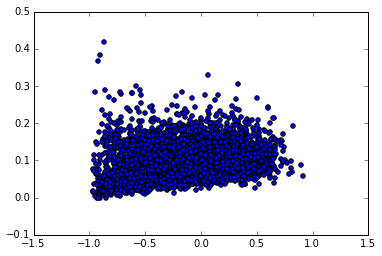

In [203]:
plt.scatter(sn_df_gt_20["diff"],sn_df_gt_20['n_af_std'])

In [183]:
sn_df_gt_20 = sn_df[(sn_df['n']+sn_df["s"])>20]

In [189]:
sn_df.ix['NFIX']

n            0
n_af_std   NaN
s            5
diff        -1
Name: NFIX, dtype: float64

In [196]:
sn_df_gt_20['compound'] = np.sign(sn_df_gt_20['diff'])*sn_df_gt_20['diff']**2+sn_df_gt_20['n_af_std']

/home/GMI/hannes.svardal/lib/python/virtualenvs/ver/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [197]:
sn_df_gt_20.sort('compound',ascending=False)

,n,n_af_std,s,diff,compound
gene_symbol,,,,,
ENSCSAG00000008486,37,0.087828,2,0.897436,0.893219
OR2C3,22,0.059000,1,0.913043,0.892649
ENSCSAG00000001298,21,0.191565,2,0.826087,0.873985
ENSCSAG00000006038,19,0.097611,2,0.809524,0.752940
ENSCSAG00000008252,20,0.068894,2,0.818182,0.738316
C1orf110,19,0.078408,2,0.809524,0.733736
CD4,20,0.172251,3,0.739130,0.718565
ENSCSAG00000009660,34,0.135081,5,0.743590,0.688007
ENSCSAG00000011762,38,0.092997,5,0.767442,0.681964


In [184]:
sn_df_gt_20.sort("diff",ascending=False)

,n,n_af_std,s,diff
gene_symbol,,,,
OR2C3,22,0.059000,1,0.913043
ENSCSAG00000008486,37,0.087828,2,0.897436
ENSCSAG00000001298,21,0.191565,2,0.826087
ENSCSAG00000008252,20,0.068894,2,0.818182
C1orf110,19,0.078408,2,0.809524
ENSCSAG00000006038,19,0.097611,2,0.809524
ZNF37A,25,0.064266,3,0.785714
ENSCSAG00000011762,38,0.092997,5,0.767442
ENSCSAG00000007682,29,0.101541,4,0.757576


In [162]:
impact_var_df[impact_var_df["impact"]=="HIGH"].sort("af_std",ascending=False)

,,gene_symbol,REF,ALT,FILTER,AA,AF,allele,effect,impact,errors,aet,cyn,pyn,pys,sab,sac,sar,tan,af_std
CHROM,POS,,,,,,,,,,,,,,,,,,,
CAEX,47049265,AKAP4,C,A,PASS,NaN,0.466258,A,stop_gained,HIGH,NaN,0.18750,1.00000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.518034
CAE16,46180030,ENSCSAG00000023715,A,G,PASS,NaN,0.546012,G,stop_lost&splice_region_variant,HIGH,WARNING_TRANSCRIPT_NO_START_CODON,1.00000,1.00000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.516398
CAE11,75076181,Metazoa_SRP,A,T,PASS,NaN,0.447853,T,stop_lost,HIGH,WARNING_TRANSCRIPT_MULTIPLE_STOP_CODONS,0.06250,1.00000,0.833333,1.000000,0.000000,0.000000,0.0,0.000000,0.510041
CAE7,97439521,ENSCSAG00000003348,G,A,PASS,NaN,0.524540,A,splice_acceptor_variant&splice_donor_variant&i...,HIGH,WARNING_TRANSCRIPT_NO_START_CODON,0.00000,1.00000,1.000000,1.000000,0.041667,0.014706,0.0,1.000000,0.505811
CAE22,95483322,U2,A,G,PASS,NaN,0.438650,G,stop_lost,HIGH,WARNING_TRANSCRIPT_MULTIPLE_STOP_CODONS,0.00000,0.93750,0.833333,1.000000,0.000000,0.000000,0.0,0.045455,0.500700
CAE11,101983690,ENSCSAG00000018940,G,C,PASS,NaN,0.503067,C,stop_gained,HIGH,WARNING_TRANSCRIPT_NO_STOP_CODON,0.00000,1.00000,0.916667,0.980392,0.000000,0.000000,0.0,0.954545,0.498022
CAE1,9938424,Y_RNA,G,A,PASS,NaN,0.500000,A,stop_gained,HIGH,WARNING_TRANSCRIPT_NO_START_CODON,0.00000,0.93750,0.916667,0.980392,0.000000,0.000000,0.0,1.000000,0.495926
CAE18,17036302,U6,A,T,PASS,NaN,0.533742,T,stop_gained,HIGH,WARNING_TRANSCRIPT_MULTIPLE_STOP_CODONS,0.09375,1.00000,1.000000,1.000000,0.000000,0.044118,0.0,1.000000,0.493084
CAE11,48208899,NR4A1,T,C,PASS,NaN,0.484663,C,splice_donor_variant&intron_variant,HIGH,NaN,0.00000,1.00000,1.000000,1.000000,0.000000,0.000000,0.0,0.545455,0.490404
